In [1]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import MultiPoint
import aesara.tensor as at

DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")

data = gpd.read_file(DATA_DIR / "spatial_income_1880.gpkg")
data["is_old"] = data.is_old.astype(int)
data = (data.drop(index=data[data.population < 5].index).dropna().reset_index())

xy = pd.DataFrame({"x": data.geometry.x, "y": data.geometry.y, "group": data.group})
grouped = xy.groupby("group").mean()

d = distance_matrix(grouped, grouped)
P_norm = StandardScaler().fit_transform(data.lutheran_ln.values.reshape(-1, 1)).flatten()
O_norm = StandardScaler().fit_transform(data.orthodox_proportion_ln.values.reshape(-1, 1)).flatten()

n = data.shape[0]
SEED = 42
N_CLUSTERS = len(data.group.unique())
assert N_CLUSTERS, N_CLUSTERS == d.shape
print(P_norm.mean())

2.0972335766236724e-16


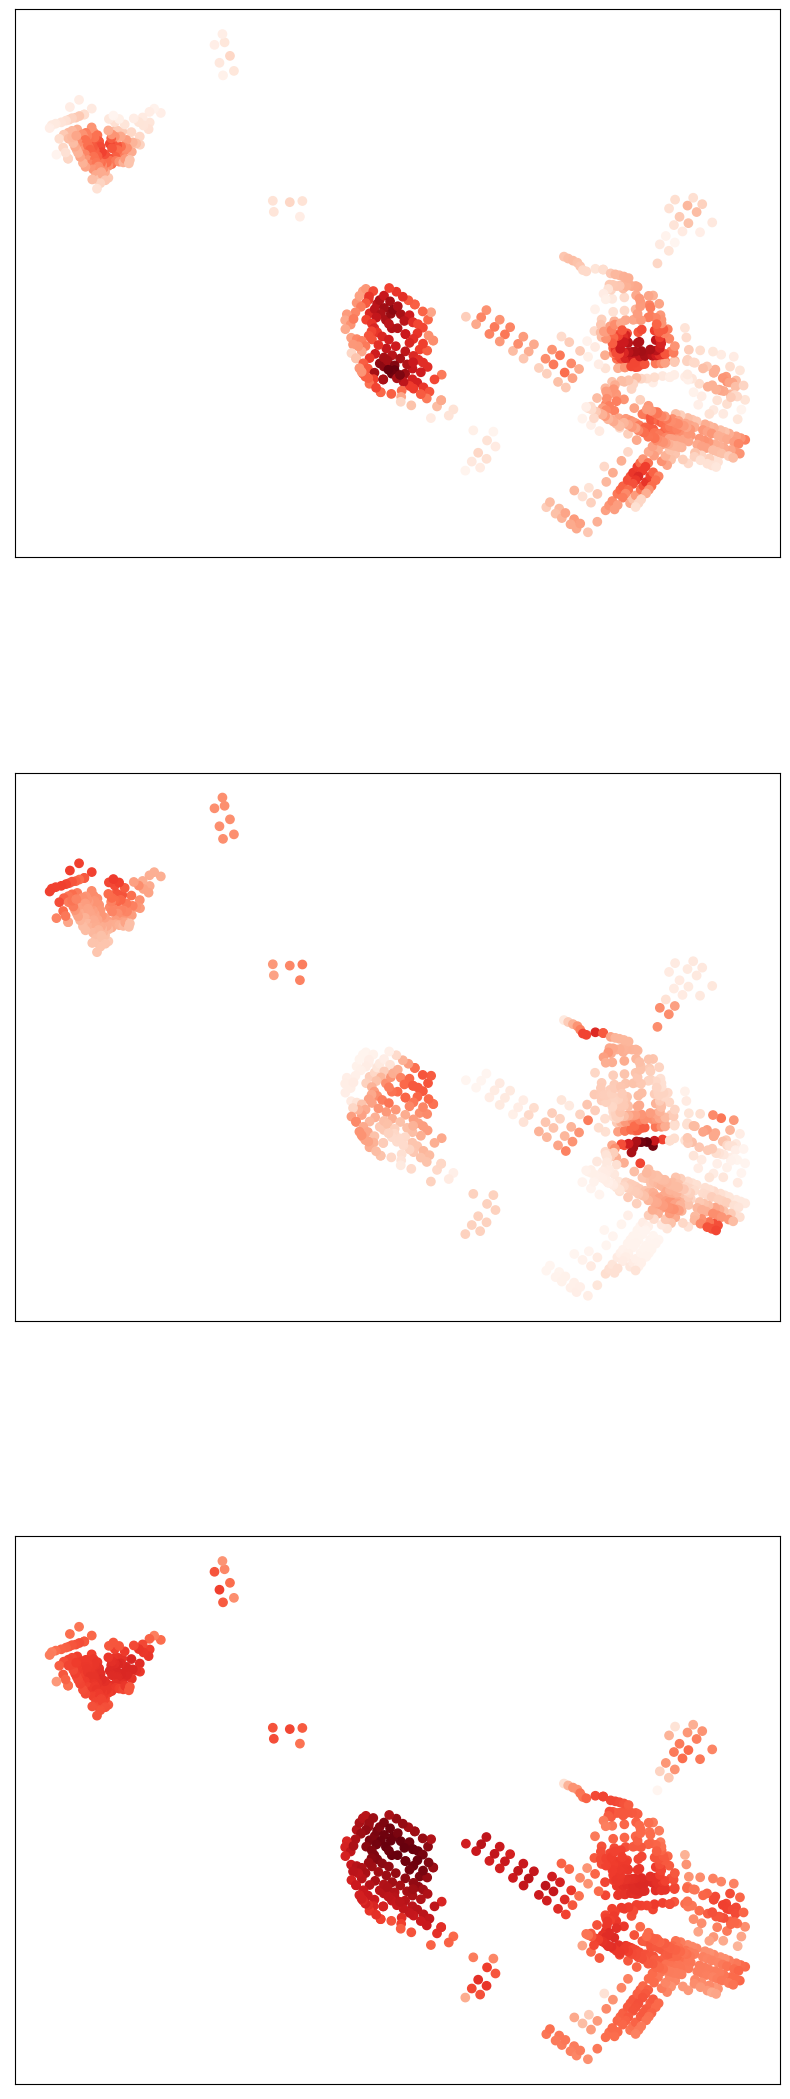

In [2]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(
    3, 1, figsize=(8, 24), subplot_kw={"xticks": [], "yticks": []}
)
data.plot(
    column="lutheran",
    cmap="Reds",
    # legend=True,
    ax=ax_1,
)
data.plot(
    column="orthodox_proportion",
    cmap="Reds",
    # legend=True,
    ax=ax_2,
)
data.plot(
    column="total_income_ln",
    cmap="Reds",
    # legend=True,
    ax=ax_3,
)
fig.tight_layout()
plt.show()

In [3]:
with pm.Model() as model_1:
    W = pm.MutableData("W", data.total_income_ln)

    β_P = pm.MvNormal(
        "β_P", np.array([0, 0]), np.array(np.diagflat([0.1, 0.1])), shape=3
    )
    μ_P = β_P[0] + β_P[1] * W
    σ_P = pm.Exponential("σ_P", 1)
    P = pm.Normal("P", mu=μ_P, sigma=σ_P, observed=P_norm)

    β_O = pm.MvNormal(
        "β_O", np.array([0, 0]), np.array(np.diagflat([0.1, 0.1])), shape=3
    )

    μ_O = β_O[0] + β_O[1] * W
    σ_O = pm.Exponential("σ_O", 1)
    O = pm.Normal("O", mu=μ_O, sigma=σ_O, observed=O_norm)

    prior_1 = pm.sample_prior_predictive()
    posterior_1 = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction_1 = pm.sample_posterior_predictive(posterior_1)

Sampling: [O, P, β_O, β_P, σ_O, σ_P]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_P, σ_P, β_O, σ_O]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [O, P]


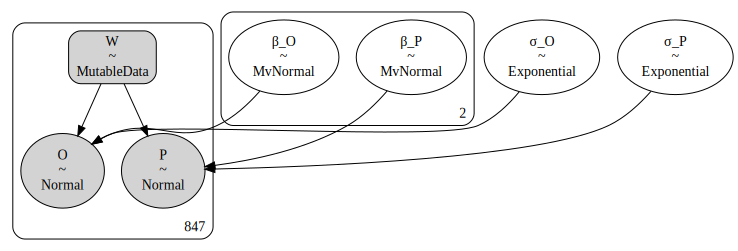

In [4]:
graph_1 = pm.model_to_graphviz(model_1)
graph_1

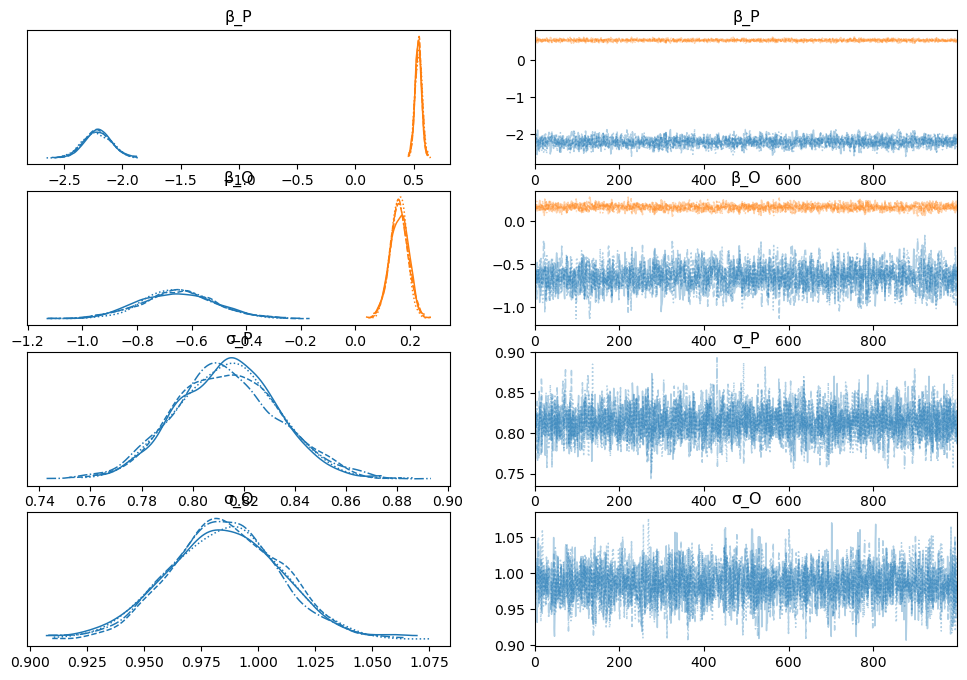

In [5]:
# az.plot_posterior(posterior_1)
az.plot_trace(posterior_1)
plt.show()

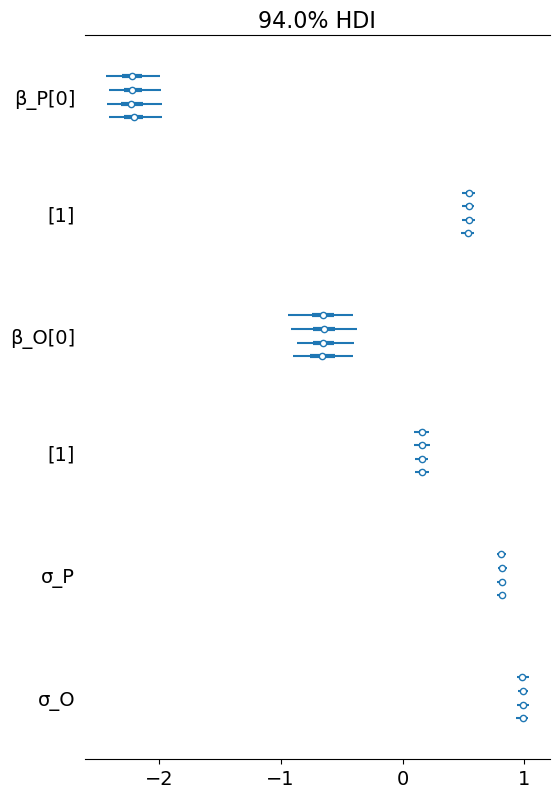

In [6]:
az.plot_forest(posterior_1, combined=False, hdi_prob=0.94)
plt.show()

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


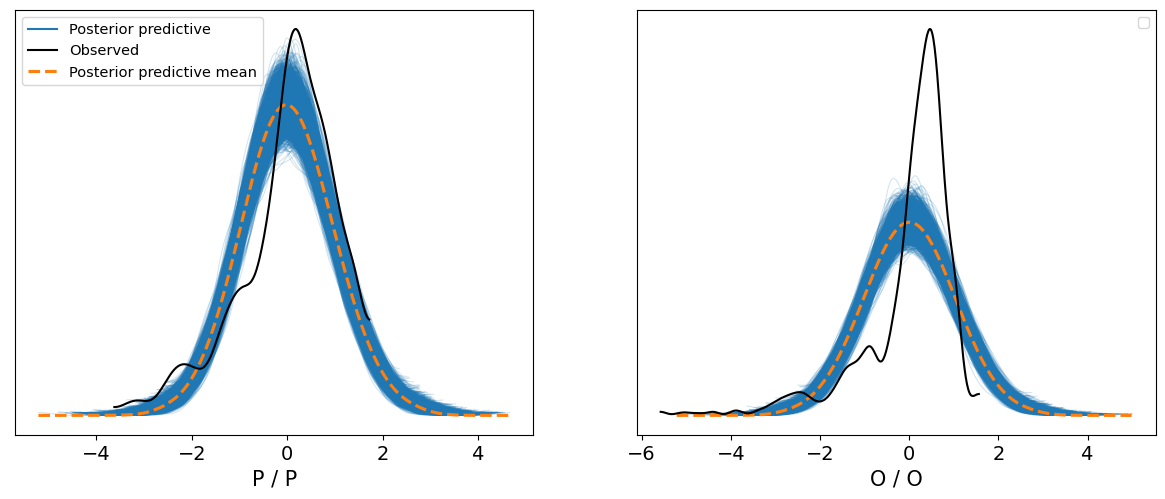

In [7]:
az.plot_ppc(posterior_prediction_1)
plt.show()

# Clustering

In [8]:
cluster_colors = plt.get_cmap("tab20")
data.explore(
    column="group",
    categorical=True,
    cmap=cluster_colors,
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

<AxesSubplot: xlabel='total_income_ln', ylabel='orthodox_proportion'>

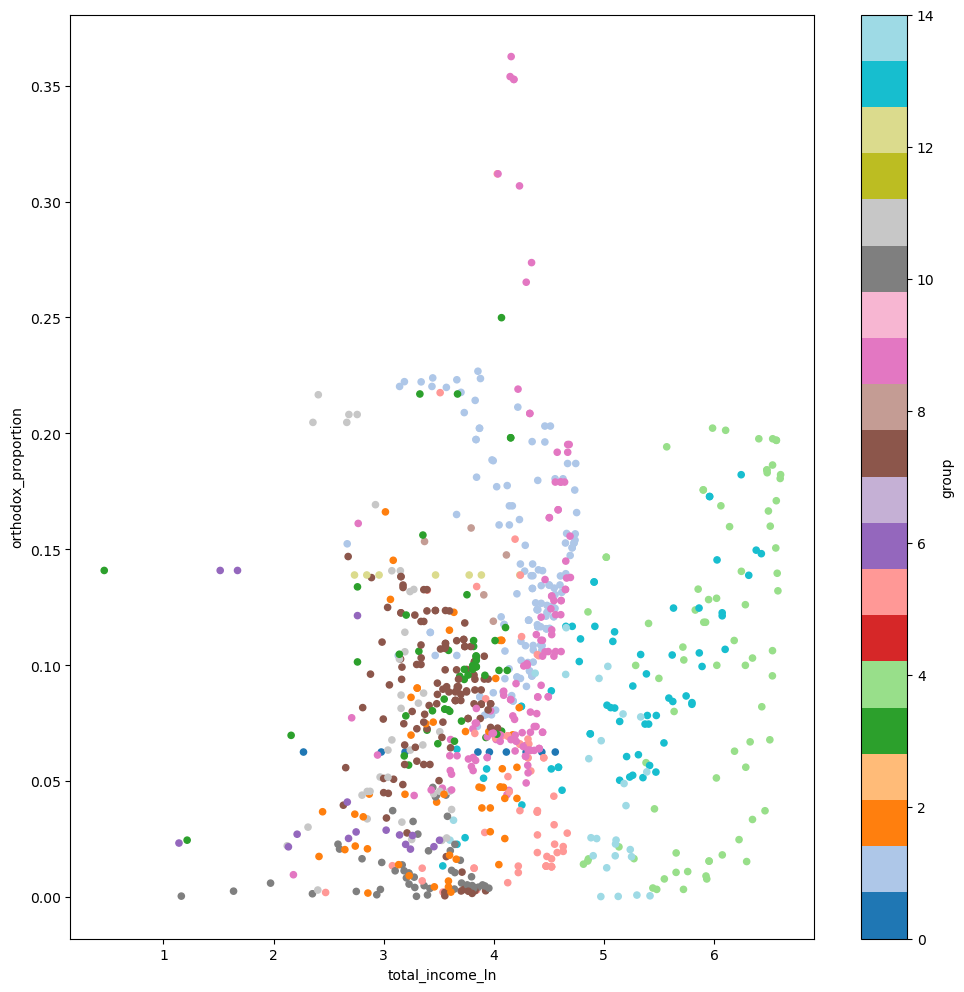

In [9]:
data.plot(
    kind='scatter', x='total_income_ln', y='orthodox_proportion', c='group', cmap='tab20', figsize=(12, 12),
)
# for i in sorted(data.group.unique()):
    # data.loc[data.group == i, :].plot(kind='scatter', x='total_income_ln', y='orthodox_proportion')
    # plt.title(i)
    # plt.show()

# Final model with 12 geographical clusters (K-means)

$$ P_i \sim N(μ_{P,i}, σ_P), i = 0, 1, ... 846 $$
$$ O_i \sim N(μ_{O,i}, σ_O), i = 0, 1, ... 846 $$
$$ mi_{P,i} = [1 \; W]  β_{P,k[i]}, i = 0, 1, ... 846, k = 0, 1, ... 11 $$
$$ μ_{O,i} = [1 \; W]  β_{O,k[i]}, i = 0, 1, ... 846, k = 0, 1, ... 11 $$
$$ σ_P \sim Exp(1) $$
$$ σ_O \sim Exp(1) $$
$$ β_{P,k} \sim MvNormal \left( θ_P, \begin{bmatrix} 0.01 & 0 \\ 0 & 0.01 \end{bmatrix} \right), k = 0, 1, ... 11 $$
$$ β_{O,k} \sim MvNormal \left( θ_O, \begin{bmatrix} 0.01 & 0 \\ 0 & 0.01 \end{bmatrix} \right), k = 0, 1, ... 11 $$
$$ θ_{P} \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
$$ θ_{O} \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
where W is Component 3, i indicates the cadastral plot, and k[i] the cluster of the cadastral plot

In [2]:
with pm.Model() as model_2:
    idx = data.group

    η2 = pm.HalfStudentT('η²', 1, 10)
    ρ2 = pm.HalfStudentT('ρ²', 1, 10)

    K = η2 * (at.exp(-ρ2 * np.power(d, 2) ** 2) + np.diag([0.01] * N_CLUSTERS))
    
    γ_P = pm.MvNormal("γ_P", mu=np.zeros(N_CLUSTERS), cov=K, shape=N_CLUSTERS)
    γ_O = pm.MvNormal("γ_O", mu=np.zeros(N_CLUSTERS), cov=K, shape=N_CLUSTERS)

    α_P = pm.Normal("α_P", 0, 0.1)
    α_O = pm.Normal("α_O", 0, 0.1)

    σ_P = pm.HalfStudentT("σ_P", 0.01, 100)
    σ_O = pm.HalfStudentT("σ_O", 0.01, 100)

    P = pm.Normal("P", mu=α_P + γ_P[idx], sigma=σ_P, observed=P_norm)
    O = pm.Normal("O", mu=α_O + γ_O[idx], sigma=σ_O, observed=O_norm)

    prior_2 = pm.sample_prior_predictive(samples=100, random_seed=SEED)
    posterior_2 = pm.sample(
        draws=1000,
        tune=1000,
        init="adapt_diag",
        return_inferencedata=True,
        target_accept=0.9,
        random_seed=SEED,
    )
    posterior_prediction_2 = pm.sample_posterior_predictive(
        posterior_2, 
        random_seed=SEED,
    )

Sampling: [O, P, a_O, a_P, γ_O, γ_P, η², ρ², σ_O, σ_P]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η², ρ², γ_P, γ_O, a_P, a_O, σ_P, σ_O]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 268 seconds.
Sampling: [O, P]


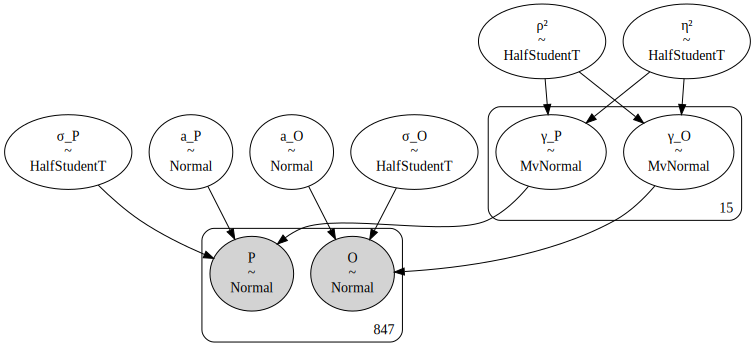

In [3]:
graph_2 = pm.model_to_graphviz(model_2)
graph_2

## Prior predictive check

In [4]:
# prior = prior_2["prior"]
# x = xr.DataArray(np.linspace(-5, 5, 100), dims=["x"])
# y = prior["β_P"][:, :, 0, 0] + prior["β_P"][:, :, 0, 1] * x
# _, ax = plt.subplots()
# ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.1)
# ax.set_xlabel("W")
# ax.set_ylabel("μ_P")

In [5]:
# x = xr.DataArray(np.linspace(-5, 5, 100), dims=["x"])
# y = prior["β_O"][:, :, 0, 0] + prior["β_O"][:, :, 0, 1] * x
# _, ax = plt.subplots()
# ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.1)
# ax.set_xlabel("W")
# ax.set_ylabel("μ_O")

## Posterior predictive check

array([<AxesSubplot: xlabel='P / P'>, <AxesSubplot: xlabel='O / O'>],
      dtype=object)

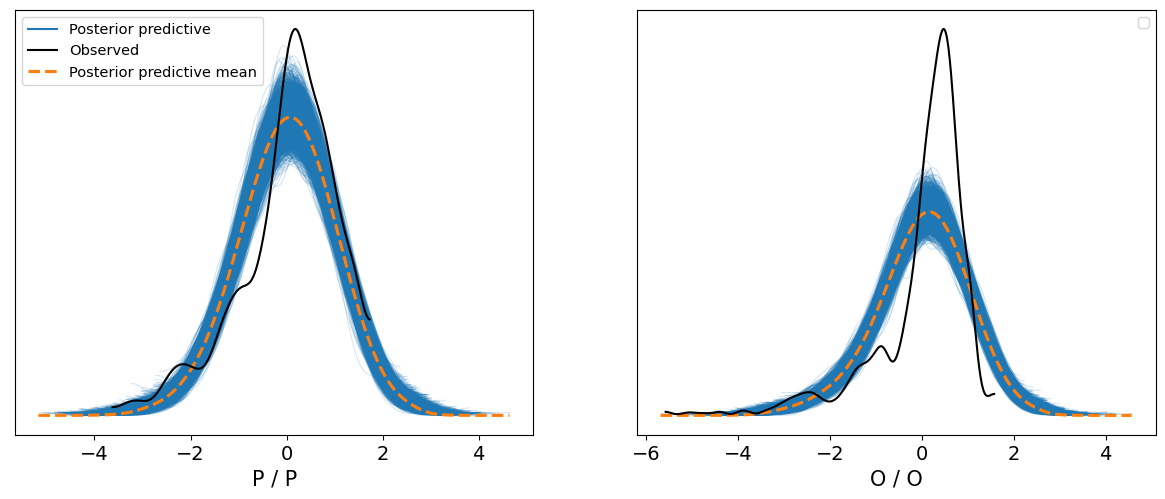

In [6]:
az.plot_ppc(posterior_prediction_2)

## Trace plots

In [7]:
az.summary(posterior_2, hdi_prob=0.95)

mean         sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
γ_P[0]    -1.819      0.266    -2.351     -1.322      0.005    0.004   
γ_P[1]    -0.175      0.111    -0.394      0.045      0.004    0.003   
γ_P[2]    -0.925      0.139    -1.196     -0.651      0.004    0.003   
γ_P[3]    -0.488      0.143    -0.776     -0.216      0.004    0.003   
γ_P[4]     0.916      0.130     0.679      1.186      0.004    0.003   
γ_P[5]    -0.234      0.135    -0.504      0.023      0.004    0.003   
γ_P[6]    -1.375      0.214    -1.814     -0.980      0.004    0.003   
γ_P[7]     0.313      0.115     0.089      0.536      0.004    0.003   
γ_P[8]    -1.222      0.340    -1.863     -0.551      0.005    0.004   
γ_P[9]     0.541      0.114     0.314      0.759      0.004    0.003   
γ_P[10]    0.103      0.144    -0.168      0.398      0.004    0.003   
γ_P[11]   -0.340      0.155    -0.629     -0.040      0.004    0.003   
γ_P[12]   -1.664      0.303    -2.269     -1.085      0.006    0.004   
γ_P[13]    0.885      0.132     0.622      1.144      0.004    0.003   
γ_P[14]    0.087      0.171    -0.247      0.414      0.004    0.003   
γ_O[0]     0.007      0.266    -0.525      0.512      0.005    0.004   
γ_O[1]     0.673      0.111     0.458      0.881      0.004    0.003   
γ_O[2]    -0.440      0.140    -0.702     -0.153      0.004    0.003   
γ_O[3]     0.403      0.142     0.130      0.683      0.004    0.003   
γ_O[4]     0.048      0.128    -0.190      0.312      0.004    0.003   
γ_O[5]    -0.576      0.134    -0.857     -0.327      0.004    0.003   
γ_O[6]    -0.493      0.212    -0.898     -0.076      0.004    0.003   
γ_O[7]     0.059      0.114    -0.169      0.275      0.004    0.003   
γ_O[8]     0.636      0.329    -0.055      1.230      0.005    0.004   
γ_O[9]     0.377      0.114     0.148      0.589      0.004    0.003   
γ_O[10]   -1.870      0.143    -2.147     -1.600      0.004    0.003   
γ_O[11]    0.041      0.153    -0.259      0.331      0.004    0.003   
γ_O[12]    0.638      0.285     0.067      1.191      0.005    0.004   
γ_O[13]    0.237      0.132    -0.013      0.493      0.004    0.003   
γ_O[14]   -1.002      0.173    -1.322     -0.650      0.004    0.003   
a_P       -0.064      0.092    -0.249      0.109      0.004    0.003   
a_O       -0.014      0.091    -0.199      0.154      0.003    0.002   
η²         0.789      0.241     0.391      1.245      0.004    0.003   
ρ²       418.220  12810.971     0.006    120.463    301.688  213.360   
σ_P        0.783      0.019     0.746      0.819      0.000    0.000   
σ_O        0.776      0.019     0.741      0.814      0.000    0.000   

         ess_bulk  ess_tail  r_hat  
γ_P[0]     2888.0    2737.0   1.00  
γ_P[1]      888.0    1607.0   1.01  
γ_P[2]     1299.0    2328.0   1.00  
γ_P[3]     1362.0    2147.0   1.00  
γ_P[4]     1054.0    2008.0   1.00  
γ_P[5]     1246.0    2382.0   1.00  
γ_P[6]     2340.0    2540.0   1.00  
γ_P[7]      949.0    1695.0   1.01  
γ_P[8]     3946.0    3140.0   1.00  
γ_P[9]      907.0    1758.0   1.01  
γ_P[10]    1385.0    1791.0   1.00  
γ_P[11]    1424.0    2437.0   1.00  
γ_P[12]    2364.0    2073.0   1.00  
γ_P[13]    1245.0    1806.0   1.00  
γ_P[14]    1782.0    2431.0   1.00  
γ_O[0]     3439.0    2999.0   1.00  
γ_O[1]      923.0    1854.0   1.00  
γ_O[2]     1316.0    2510.0   1.00  
γ_O[3]     1435.0    2347.0   1.00  
γ_O[4]     1107.0    1933.0   1.00  
γ_O[5]     1161.0    2023.0   1.00  
γ_O[6]     2672.0    2692.0   1.00  
γ_O[7]      953.0    1873.0   1.00  
γ_O[8]     3918.0    3392.0   1.00  
γ_O[9]      984.0    1892.0   1.00  
γ_O[10]    1318.0    2410.0   1.00  
γ_O[11]    1543.0    2462.0   1.00  
γ_O[12]    3366.0    2568.0   1.00  
γ_O[13]    1134.0    2074.0   1.00  
γ_O[14]    2011.0    2292.0   1.00  
a_P         648.0    1323.0   1.01  
a_O         673.0    1245.0   1.00  
η²         4091.0    2934.0   1.00  
ρ²         2983.0    1866.0   1.00  
σ_P        6963.0    3222.0   1.00  
σ_O        7516

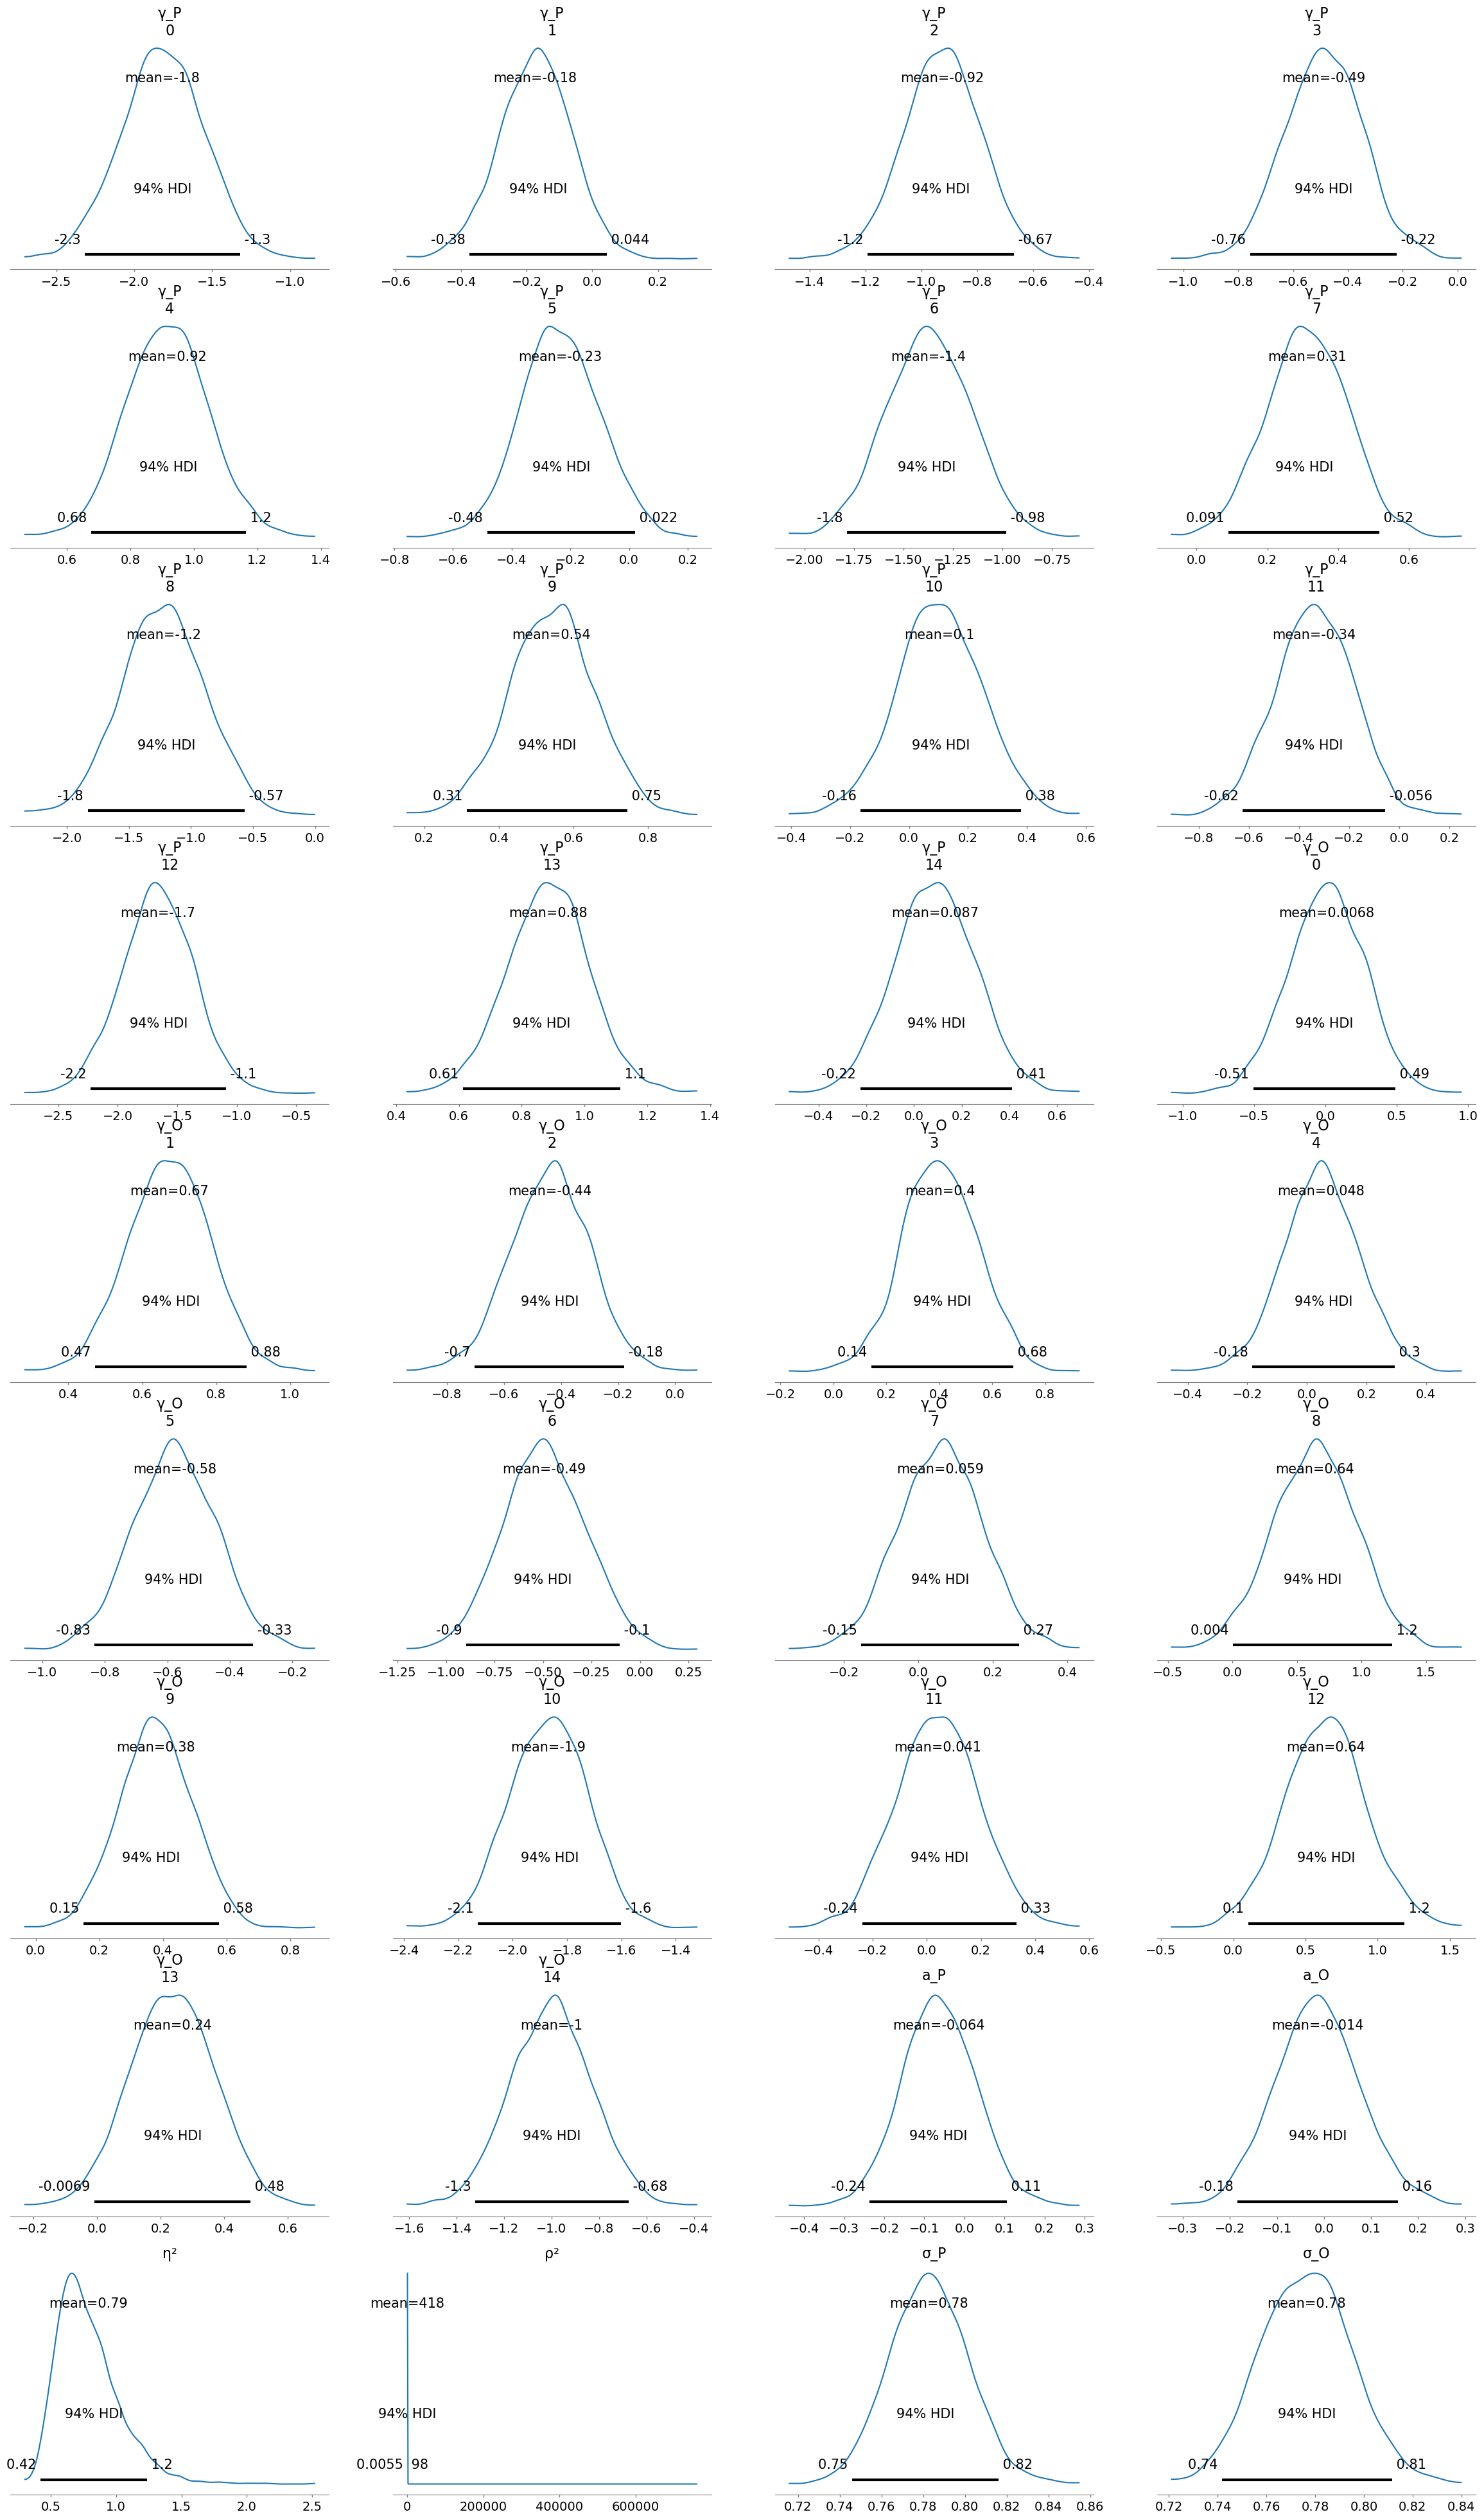

In [8]:
az.plot_posterior(posterior_2)
plt.show()

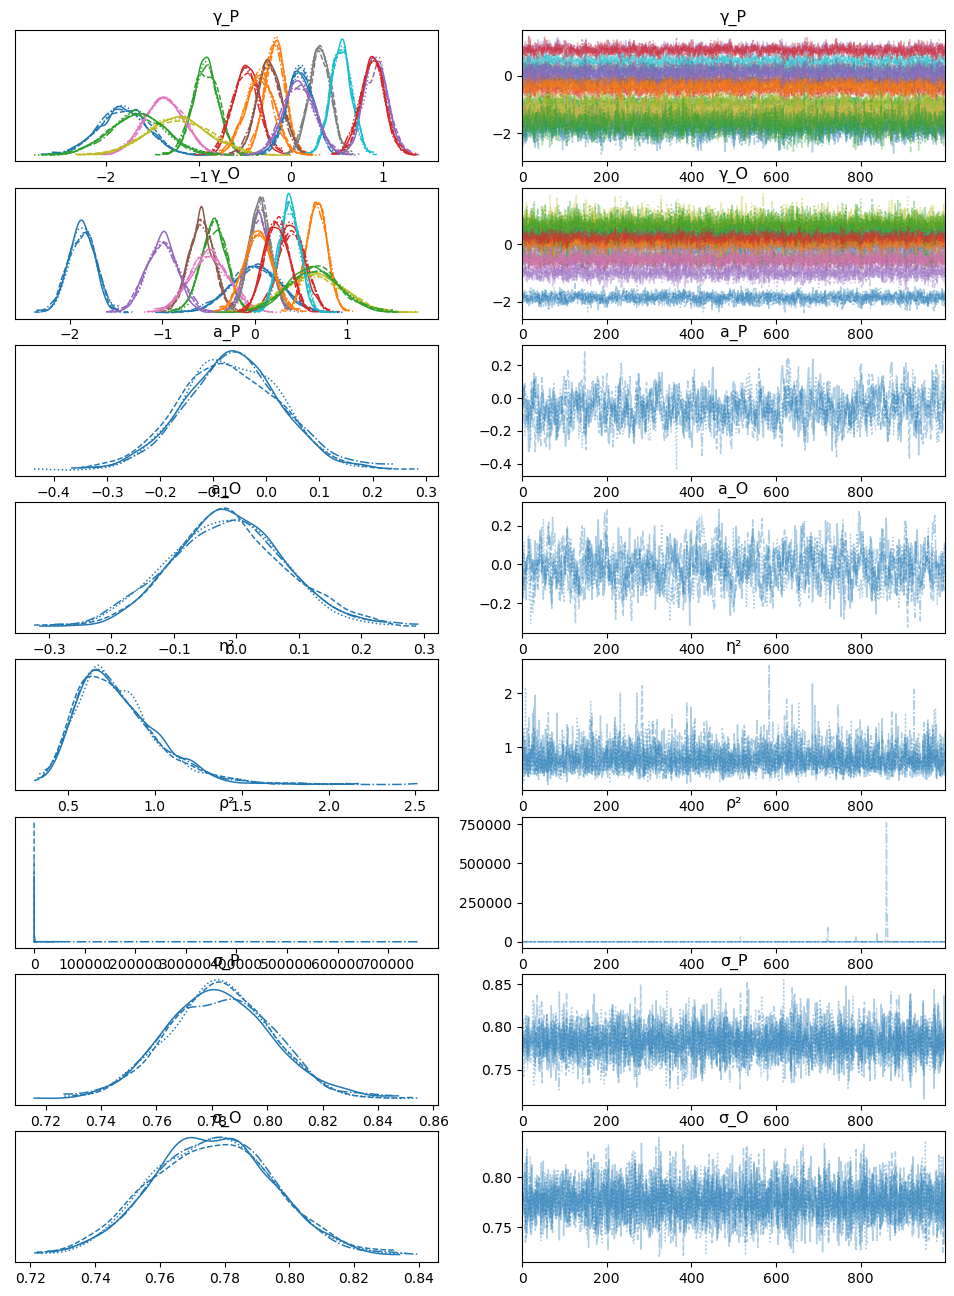

In [9]:
az.plot_trace(posterior_2)
plt.show()

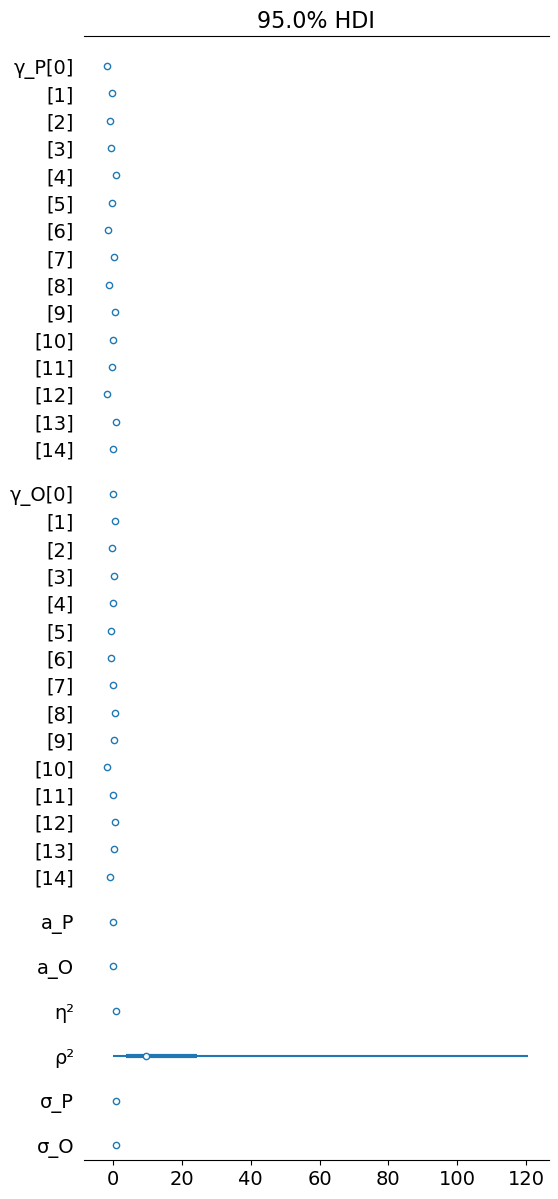

In [10]:
az.plot_forest(posterior_2, combined=True, hdi_prob=0.95)
plt.show()